# 1. Import packages

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# 2. Loading a pre-processed data set

In [2]:
path = './dataset/toyset/'
filename = 'processed_toyset.csv'
df = pd.read_csv(path + filename)

#### Define dataset row/column sizes to begin with

In [3]:
df.loc[:, 'gbpusd'] = df.loc[:, 'gbpusd']*100
df.loc[:, 'gbpjpy'] = df.loc[:, 'gbpjpy']*100
df.loc[:, 'usdjpy'] = df.loc[:, 'usdjpy']*100

In [4]:
nrow = 3
ncol = 3

In [5]:
proc_covar = 0.0001**2*np.identity(nrow)
post_covar = proc_covar
meas_covar = 0.0003**2*np.identity(nrow)
pred_covar = meas_covar
ident = np.identity(nrow)

In [6]:
state_old = np.ones((3, 1), dtype=np.float64)
emit_mat = np.array([[1., -1, 0.],
                     [1.,  0, -1.],
                     [0., -1., 1.],
                     ], dtype=np.float64)
obs_mat = df.drop(['timestamp', 'time_gap'], axis=1)
obs_mat = obs_mat.to_numpy()
time_gap = df.time_gap.to_numpy().reshape(-1, 1)

latent_states = np.empty(shape=(df.shape[0], nrow), dtype=np.float64)
predicted_obs = np.empty(shape=(df.shape[0], nrow), dtype=np.float64)

## Kalman updates

#### Assumptions:
- the order of measurements is GBPJPY, GBPUSD, USDJPY.
- the order of latent variables is GBP, JPY, USD.

In [7]:
ccy_list = ['gbpjpy', 'gbpusd', 'usdjpy']
latent_cols = ['GBP', 'JPY', 'USD']

In [8]:
for i in range(df.shape[0]):
    post_covar = post_covar + time_gap[i]*proc_covar

    # obs_mat[i,:] is a (3,) vector. So, we need flatten() to match
    innovation = obs_mat[i, :] - (emit_mat@state_old).flatten()
    innovation_covar = emit_mat@post_covar@(emit_mat.T) + meas_covar
    kalman_gain = post_covar@(emit_mat.T)@np.linalg.inv(innovation_covar)

    # We transpose (kalman_gain@innovation) from (3,) to (3,1)
    state_new = state_old + (kalman_gain@innovation).reshape(-1, 1)
    post_covar = (ident - kalman_gain@emit_mat)@post_covar
    predicted_obs[i] = (emit_mat@state_new).T
    latent_states[i] - state_new.T
    state_old = state_new

#### Remove the oldest timestamp and shift each row upward by one row.
- e.g. If the raw dataset starts from 2019-05-01 00:00:00 at 0th element, predictions would start from 2019-05-01 00:00:01 at 0th element instead ('lead' by one minute)

In [9]:
new_idx = df.timestamp.shift(-1).to_numpy().reshape(-1, 1)
predictions = np.hstack((new_idx, predicted_obs))
latent_estimates = np.hstack((new_idx, latent_states))

In [10]:
assert predictions.shape[0] == predicted_obs.shape[0], "We have some data loss."
assert latent_estimates.shape[0] == latent_states.shape[0], "We have some data loss."

#### Convert arrays to DataFrame instances

In [11]:
predictions = pd.DataFrame(predictions, columns=['timestamp'] + ccy_list)
latent_estimates = pd.DataFrame(latent_estimates,
                                columns=['timestampe'] + latent_cols)

## How good are the predictions?

#### It's worse than the baseline. Let's see what's going on:

As we expected, currency exchange rates are extremely volatile, and our naive approach fails. Then again, the covariance matrices are not estimated in this case, and there may be a setting that works better. But on the bright side, the graph of currency intrinsic values is really neat:

## Parameter Estimation: EM

So the goal of the project is to build an adaptive Kalman Filter. However, the problem is impossible at our current level, so we have to do a middle ground. A Kalman Smoother allows us to estimate the covariance matrices through the EM algorithm, but it requires using future data to predict the past. By combining a Kalman Smoother with PSIS detailed in the next section, we construct an algorithm to do filtering in a heuristic fashion.

### E step
- The forward pass propagates through the system, given fixed covariance matrices.
- It outputs both the predicted states and the predicted measurements.

In [12]:
def forward_pass(data, initial_state, emit_mat, meas_covar, proc_covar, post_covar):
    '''
    Parameters:
      data(DataFrame, ): a (batch) dataset
    '''
    if type(data) == pd.core.series.Series:
        obs_mat = data[1:-1]
        obs_mat = obs_mat.to_numpy().reshape(1, -1)
        time_gap = np.array(data[-1]).reshape(-1, 1)
        data_nrow = 1
        new_idx = np.datetime64(data.timestamp) + np.timedelta64(data[-1], 'm')
        new_idx = np.array(str(new_idx)).reshape(-1, 1)
    else:
        obs_mat = data.drop(['timestamp', 'time_gap'], axis=1)
        obs_mat = obs_mat.to_numpy()
        time_gap = data.time_gap.to_numpy().reshape(-1, 1)
        data_nrow = data.shape[0]
        new_idx = data.timestamp.shift(-1).to_numpy().reshape(-1, 1)

    latent_states = np.empty((data_nrow, nrow))
    predicted_obs = np.empty((data_nrow, nrow))

    state_old = initial_state[1:-
                              1] if initial_state.shape[0] > nrow else initial_state

    for i in range(data_nrow):
        # post_covar = post_covar + time_gap.flatten()[i]*proc_covar
        post_covar = post_covar + time_gap.flatten()[i]*proc_covar

        # obs_mat[i,:] is a (3,) vector. So, we need flatten() to match
        innovation = obs_mat[i, :] - (emit_mat@state_old).flatten()
        innovation_covar = emit_mat@post_covar@(emit_mat.T) + meas_covar
        try:
            kalman_gain = post_covar@(emit_mat.T)@(
                np.linalg.inv(innovation_covar).astype(np.float64))
        except:
            print(i, 'error at  kalman')
            print('post_covar', post_covar, 'dtype', post_covar.dtype)
            print('emit_mat.T', emit_mat.T, 'dtype', emit_mat.dtype)
            print('innovation_covar', innovation_covar,
                  'dtype', innovation_covar.dtype)
            print('np.linalg.inv(innovation_covar)',
                  np.linalg.inv(innovation_covar))

        # We transpose (kalman_gain@innovation) from (3,) to (3,1)
        state_new = state_old.reshape(-1, 1) + \
            (kalman_gain@innovation).reshape(-1, 1)
        post_covar = (ident - kalman_gain@emit_mat)@post_covar
        predicted_obs[i] = (emit_mat@state_new).T
        latent_states[i] = state_new.T
        state_old = state_new

    predicted_obs = np.array(predicted_obs)
    latent_states = np.array(latent_states)
    predictions = np.hstack((new_idx, predicted_obs))
    predictions = np.hstack((predictions, time_gap))
    latent_estimates = np.hstack((new_idx, latent_states))
    latent_estimates = np.hstack((latent_estimates, time_gap))

    return predictions, latent_estimates, post_covar, innovation_covar

A helper function.

In [13]:
def shift(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e

### M step

In [14]:
def update_proc_scale(latent_estimates):
    '''
    Takes the scale matrix of the propagated states.
    But we have to take into account the uneven time gaps.
    '''

    latent_estimates = latent_estimates[:-1, :]  # drop nan
    time_gap_rep = np.repeat(
        latent_estimates[:, -1].astype(np.float64), repeats=nrow).reshape(-1, nrow)
    latent_estimates = latent_estimates[:, 1:-1]
    latent_estimates = (
        latent_estimates - shift(latent_estimates, 1)).astype(np.float64) / time_gap_rep
    latent_estimates = latent_estimates[~np.isnan(
        latent_estimates)].reshape(-1, nrow)    # drop nan

    proc_scale = (latent_estimates.T)@latent_estimates

    return proc_scale


def update_meas_scale(pred, obs):
    '''
    Gets us the observed scale matrix through (biased) MLE.
    The debiasing is done by supplying the correct df to the invWishart
    '''
    pred = pred[~pd.isna(pred[:, 0]), :]
    obs_timestamp = obs['timestamp'].dropna(how='any').to_numpy()
    unique_timestamp = np.union1d(pred[:, 0], obs_timestamp)

    pred_mat = pred[np.isin(pred[:, 0], unique_timestamp)]
    obs_mat = obs[np.isin(obs_timestamp, unique_timestamp)]

    # Convert np to dataframe
    pred_mat = pd.DataFrame(
        pred_mat, columns=['timestamp'] + ccy_list + ['time_gap'])
    obs_pred_mat = pd.merge(left=obs_mat, right=pred_mat,
                            how='inner', on='timestamp', suffixes=('_obs', '_pred'))

    ccy_list_obs = [ccy+'_obs' for ccy in ccy_list]
    ccy_list_pred = [ccy+'_pred' for ccy in ccy_list]

    error_mat = np.array(obs_pred_mat[ccy_list_pred], dtype=float) - \
        np.array(obs_pred_mat[ccy_list_obs], dtype=float)
    return (error_mat.T)@error_mat

In [ ]:
predicted_measurements, states,\
    ps_covar, innovation_covar = \
    forward_pass(data=data, initial_state=prior_state,
                 emit_mat=emit_mat,
                 meas_covar=prior_meas_scale/prior_meas_df,
                 proc_covar=prior_proc_scale/prior_proc_df,
                 post_covar=post_covar)

### EM (Kalman smoother)

In [15]:
def kalman_smoother(data, prior_state, emit_mat, post_covar, prior_meas_df, prior_meas_scale, prior_proc_df, prior_proc_scale):
    '''
    Runs the smoother on a time block through EM
    '''
    nrow_data = data.shape[0]
    predicted_measurements, states, ps_covar, \
        innovation_covar = forward_pass(data=data, initial_state=prior_state,
                                        emit_mat=emit_mat, meas_covar=prior_meas_scale/prior_meas_df,
                                        proc_covar=prior_proc_scale/prior_proc_df,
                                        post_covar=post_covar)

    post_proc_scale = update_proc_scale(states)
    post_meas_scale = update_meas_scale(pred=predicted_measurements, obs=data)

    old_proc_scale = post_proc_scale*2
    old_meas_scale = post_meas_scale*2

    while np.sqrt(np.sum(((old_proc_scale - post_proc_scale)/nrow_data)**2) +
                  np.sum(((old_meas_scale-post_meas_scale)/nrow_data)**2)) > 10**(-9):

        print(np.sqrt(np.sum(((old_proc_scale - post_proc_scale)/nrow_data)**2) +
                      np.sum(((old_meas_scale-post_meas_scale)/nrow_data)**2)))

        old_meas_scale = post_meas_scale
        old_proc_scale = post_proc_scale

        predicted_measurements, states, ps_covar, \
            innovation_covar = forward_pass(data=data, initial_state=prior_state,
                                            emit_mat=emit_mat,
                                            meas_covar=post_meas_scale/nrow_data,
                                            proc_covar=post_proc_scale/nrow_data,
                                            post_covar=post_covar)

        post_proc_scale = update_proc_scale(states)
        post_meas_scale = update_meas_scale(
            pred=predicted_measurements, obs=data)

    post_proc_df = prior_proc_df + nrow_data
    post_meas_df = prior_meas_df + nrow_data

    result = {
        'input_data': data,
        'states': states,
        'predicted_measurements': predicted_measurements,
        'post_meas_df': post_meas_df,
        'post_meas_scale': prior_meas_scale + post_meas_scale,
        'post_proc_df': post_proc_df,
        'post_proc_scale': prior_proc_scale + post_proc_scale,
        'post_covar': ps_covar,
        'innovation_covar': innovation_covar
    }

    return result

In [16]:
training = df.loc[10000:11999, :]

forward_predictions, forward_states, \
    forward_post_covar, forward_innoation_covar = forward_pass(data=training[:100],
                                                               initial_state=np.array(
        [270, -220, 250]),
        emit_mat=emit_mat,
        meas_covar=1 *
        np.identity(
        nrow),
        proc_covar=0.01 *
        np.identity(
        nrow),
        post_covar=0.01*np.identity(nrow))

In [17]:
# Convert to pandas Data Frame
forward_predictions = pd.DataFrame(forward_predictions,
                                   columns=['timestamp'] + ccy_list + ['time_gap'])

In [113]:
# Code: https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None:
        cols = data.columns
    if len(cols) == 0:
        return
    colors = getattr(getattr(plotting, '_matplotlib').style,
                     '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
#     ax.set_ylabel(ylabel=cols[0])
    ax.tick_params(axis='y', colors=colors[0])
    lines, labels = ax.get_legend_handles_labels()

#     for n in range(1, len(cols)):
#         # Multiple y-axes
#         ax_new = ax.twinx()
#         ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
#         data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
#         ax_new.set_ylabel(ylabel=cols[n])
#         ax_new.tick_params(axis='y', colors=colors[n % len(colors)])

#         # Proper legend position
#         line, label = ax_new.get_legend_handles_labels()
#         lines += line
#         labels += label

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax.set_ylabel(ylabel=cols[n])
        ax.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(
            ax=ax, label=cols[n], color=colors[n % len(colors)])
        ax.tick_params(axis='y', colors=colors[n % len(colors)])

        # Proper legend position
        line, label = ax.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

In [117]:
gbpusd_dict = {'gbpusd(pred)': forward_predictions.iloc[20:100, 1].to_numpy(),
               'gbpusd(training)': training.iloc[20:100, 1].to_numpy()}

In [123]:
forward_predictions

,timestamp,gbpjpy,gbpusd,usdjpy,time_gap
0,2019-05-09 17:41:00,490.358,20.3608,469.997,1
1,2019-05-09 17:42:00,490.831,20.8395,469.991,1
2,2019-05-09 17:43:00,491.365,21.3849,469.98,1
3,2019-05-09 17:44:00,491.914,21.9537,469.96,1
4,2019-05-09 17:45:00,492.451,22.5106,469.941,1
...,...,...,...,...,...
95,2019-05-09 19:16:00,496.252,26.4709,469.781,1
96,2019-05-09 19:17:00,496.25,26.4686,469.781,1
97,2019-05-09 19:18:00,496.247,26.4661,469.781,1
98,2019-05-09 19:19:00,496.246,26.4645,469.782,1


In [124]:
training

,timestamp,gbpjpy,gbpusd,usdjpy,time_gap
10000,2019-05-09 17:40:00,496.324315,26.374792,469.951626,1
10001,2019-05-09 17:41:00,496.290057,26.367878,469.924324,1
10002,2019-05-09 17:42:00,496.229903,26.357123,469.874249,1
10003,2019-05-09 17:43:00,496.177413,26.367110,469.809571,1
10004,2019-05-09 17:44:00,496.178113,26.374792,469.805014,1
...,...,...,...,...,...
11995,2019-05-12 21:55:00,496.067444,26.177948,469.829616,1
11996,2019-05-12 21:56:00,496.067444,26.177948,469.829616,1
11997,2019-05-12 21:57:00,496.067444,26.177948,469.829616,1
11998,2019-05-12 21:58:00,496.067444,26.177948,469.829616,1


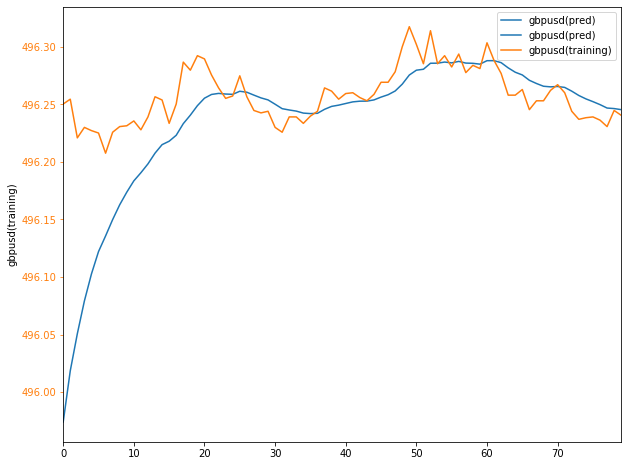

In [122]:
plot_multi(pd.DataFrame(gbpusd_dict), figsize=(10,8))

In [21]:
check_smoother = kalman_smoother(data=training[:1000],
                                 prior_state=np.array(
                                     [270, -220, 250], dtype=np.float64),
                                 emit_mat=emit_mat,
                                 prior_meas_df=100,
                                 prior_meas_scale=1**2 *
                                 np.identity(
                                     emit_mat.shape[1], dtype=np.float64),
                                 prior_proc_df=100,
                                 prior_proc_scale=0.1**2 *
                                 np.identity(
                                     emit_mat.shape[0], dtype=np.float64),
                                 post_covar=forward_post_covar
                                 )

0.001200237820831532
0.0005090922751997935
5.3481212135710275e-05
4.42118456440653e-05
4.234581750414229e-05
4.121240316831518e-05
4.025262646542879e-05
3.935025413037312e-05
3.844403791435025e-05
3.74900267937802e-05
3.645289438164791e-05
3.530466510147192e-05
3.402559165956555e-05
3.2605301409941585e-05
3.1043511479081705e-05
2.935001834460855e-05
2.754385198324971e-05
2.565162753857177e-05
2.370526117232664e-05
2.1739324706281465e-05
1.9788368027664463e-05
1.788452781829555e-05
1.605566660471025e-05
1.4324175719047664e-05
1.2706456394165041e-05
1.1212995053975894e-05
9.848887888655776e-06
8.614648307416102e-06
7.507143054296905e-06
6.520533609042014e-06
5.647138626284574e-06
4.878169947811793e-06
4.204324460785212e-06
3.616234183827994e-06
3.104789877975739e-06
2.6613584582309176e-06
2.2779162968654242e-06
1.947118401730395e-06
1.6623212508194364e-06
1.4175733209200425e-06
1.2075843957292788e-06
1.0276819416605645e-06
8.737607002582839e-07
7.422296181492193e-07
6.299590170458646e-07

#### We inspect the Bayes estimates of the covariance matrices:

In [22]:
check_smoother['post_meas_scale'] / \
    (check_smoother['post_meas_df'] - emit_mat.shape[0])

array([[1.87193778e-03, 4.86233977e-04, 4.28434730e-04],
       [4.86233977e-04, 1.32899856e-03, 6.70738290e-05],
       [4.28434730e-04, 6.70738290e-05, 1.28628750e-03]])

In [23]:
check_smoother['post_proc_scale'] / \
    (check_smoother['post_proc_df'] - emit_mat.shape[1])

array([[ 1.08797865e-05, -1.80430081e-06,  4.02845822e-08],
       [-1.80430081e-06,  1.23879761e-05, -1.46790502e-06],
       [ 4.02845822e-08, -1.46790502e-06,  1.05433907e-05]])

#### And can visually inspect how the smoother performs on individual currencies:

In [24]:
usdjpy_dict = {'usdjpy(pred)': check_smoother['predicted_measurements'][0:100][:, -2],
               'usdjpy(training)': check_smoother['input_data'][0:100].loc[:, 'usdjpy'].to_numpy()}

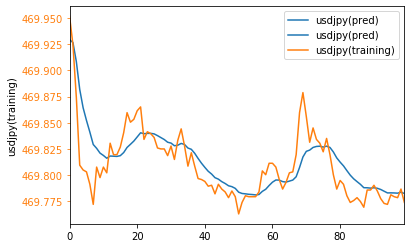

In [25]:
plot_multi(pd.DataFrame(usdjpy_dict))

#  PSIS

PSIS is like our alarm that rings whenever the predictions become really bad and we need to update our parameters through smoothing. In particular, we fit the generalized Pareto distribution to the 20% highest importance weights, and if k > 0.7, we refit because we think the variance of the importance weights is infinity.

To do this, we sample 1000 covariance matrices at the start of our forward pass through the filter and hold those fixed (covariance matrices are very expensive to sample)

In [26]:
from scipy.stats import invwishart, multivariate_normal

In [27]:
# Source: https://github.com/avehtari/PSIS/blob/master/py/psis.py
def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)
    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.
    Parameters
    ----------
    x : ndarray
        One dimensional data array
    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.
    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).
    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.
    Returns
    -------
    k, sigma : float
        estimated parameter values
    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.
    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.
    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:, None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:, None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        return k, sigma, ks, w
    else:
        return k, sigma

#### We inspect the Bayes estimates of the covariance matrices:

In [28]:
def kalman_filter_minibatch(data, emit_mat, initial_state, innovation_covar, post_covar,
                            prior_proc_df, prior_proc_scale,
                            prior_meas_df, prior_meas_scale
                            ):
    batch_size = 200
    data_nrow = data.shape[0]
    proc_cov_mats = invwishart.rvs(
        df=prior_proc_df, scale=prior_proc_scale, size=batch_size)
    meas_cov_mats = invwishart.rvs(
        df=prior_meas_df, scale=prior_meas_scale, size=batch_size)

    psis_k = 0
    iter_count = 0
    data_count = 0
    initial_state = initial_state[1:-
                                  1] if initial_state.shape[0] > nrow else initial_state
    parallel_states = np.expand_dims(initial_state, axis=0)
    parallel_states = parallel_states.repeat(batch_size, axis=0)
    innovation_covar_mats = np.expand_dims(innovation_covar, axis=0)
    innovation_covar_mats = innovation_covar_mats.repeat(batch_size, axis=0)
    post_cov_mats = np.expand_dims(post_covar, axis=0)
    post_cov_mats = post_cov_mats.repeat(batch_size, axis=0)

    latent_states = []
    innovation_covar = []
    importance_weights = []

    while (psis_k < 0.7) and (iter_count < data_nrow):
        for i in range(parallel_states.shape[0]):
            temp1, temp2, temp3, temp4 = forward_pass(data=data.iloc[iter_count, :],
                                                      initial_state=initial_state,
                                                      emit_mat=emit_mat,
                                                      meas_covar=meas_cov_mats[i, :, :],
                                                      proc_covar=proc_cov_mats[i, :, :],
                                                      post_covar=post_cov_mats[i, :, :]
                                                      )
            parallel_states[i] = temp2[-1, 1:-1]
            innovation_covar_mats[i] = temp4
            post_cov_mats[i] = temp3

        iw = []
        for i in range(parallel_states.shape[0]):
            iw.append(multivariate_normal.logpdf(x=(data.iloc[iter_count, 1:-1]).astype(np.float64),
                                                 mean=emit_mat@(
                                                     parallel_states[i, :].astype(np.float64)),
                                                 cov=innovation_covar_mats[i, :, :]))
        importance_weights.append(iw)

        psis_weights = np.array(importance_weights)
        psis_weights = np.sum(psis_weights, axis=0)

        psis_weights = psis_weights[np.argsort(
            psis_weights)[-int(batch_size*0.2):]]
        psis_weights = np.exp(psis_weights)

        psis_k = gpdfitnew(psis_weights - np.min(psis_weights))[0]
        print('iter_count', iter_count, 'k:', psis_k)
        iter_count += 1

    forward = forward_pass(
        data=data[:iter_count],
        initial_state=initial_state,
        emit_mat=emit_mat,
        meas_covar=prior_meas_scale / (prior_meas_df - emit_mat.shape[0]),
        proc_covar=prior_proc_scale / (prior_proc_df - emit_mat.shape[1]),
        post_covar=post_covar
    )

    return forward

In [29]:
states = check_smoother['states']
check_kf_minibatch = kalman_filter_minibatch(data=training[1000:1199],
                                             emit_mat=emit_mat,
                                             initial_state=states[-1,
                                                                  1:-1].astype(np.float64),
                                             innovation_covar=check_smoother['innovation_covar'],
                                             post_covar=check_smoother['post_covar'],
                                             prior_proc_df=check_smoother['post_proc_df'],
                                             prior_proc_scale=check_smoother['post_proc_scale'],
                                             prior_meas_df=check_smoother['post_meas_df'],
                                             prior_meas_scale=check_smoother['post_meas_scale']
                                             )

iter_count 0 k: 0.2401300903740353
iter_count 1 k: 0.11199464618723834
iter_count 2 k: 0.09946114546688573
iter_count 3 k: 0.13166521118552935
iter_count 4 k: 0.1499032378324087
iter_count 5 k: 0.15947192560180268
iter_count 6 k: 0.15785407102823618
iter_count 7 k: 0.178954740698971
iter_count 8 k: 0.11737657471641363
iter_count 9 k: 0.06455265133537594
iter_count 10 k: 0.10254631717021279
iter_count 11 k: 0.09098244785286289
iter_count 12 k: 0.11050055159265192
iter_count 13 k: 0.1568971986457665
iter_count 14 k: 0.17701023458053938
iter_count 15 k: 0.2227144359440113
iter_count 16 k: 0.3451493866424913
iter_count 17 k: 0.3684579419087105
iter_count 18 k: 0.3081825511590865
iter_count 19 k: 0.28054333987187097
iter_count 20 k: 0.3774462846261053
iter_count 21 k: 0.4138956799763992
iter_count 22 k: 0.4696068700417705
iter_count 23 k: 0.5009745947593546
iter_count 24 k: 0.44289256888326645
iter_count 25 k: 0.48675627561003054
iter_count 26 k: 0.45919961295509315
iter_count 27 k: 0.45363

## Adaptive Kalman Filter

In [35]:
def adaptive_kalman_filter(data, emit_mat, prior_state, prior_covar, innovation_covar, prior_proc_df, prior_proc_scale, prior_meas_df, prior_meas_scale, burn_in=0):
    print('Adaptive KF started with a prior state of', prior_state)
    output_states = []
    output_meas = []
    output_meas_covar = []
    output_proc_covar = []
    breakpoints = []
    minibatch_count = 0
    itercount = 0
    forward = []
    nrow_data = data.shape[0]

    # if burn_in > 0:
    #     smoother = kalman_smoother(data = data[:burn_in],
    #                                 prior_state = prior_state,
    #                                 meas_mat = meas_mat,
    #                                 post_covar = prior_covar,
    #                                 prior_meas_df = prior_meas_df,
    #                                 prior_meas_scale = prior_meas_scale,
    #                                 prior_proc_df = prior_proc_df,
    #                                 prior_proc_scale = prior_proc_scale
    #     )

    #     itercount = itercount + burn_in
    #     minibatch_count = minibatch_count + 1

    # end of if

    print(itercount)

    while itercount < nrow_data:
        print('prior passed to minibatch', prior_state)
        forward1, forward2, forward3, forward4 = kalman_filter_minibatch(
            data=data[itercount:nrow_data],
            emit_mat=emit_mat,
            initial_state=prior_state,
            innovation_covar=innovation_covar,
            post_covar=prior_covar,
            prior_proc_df=prior_proc_df,
            prior_proc_scale=prior_proc_scale,
            prior_meas_df=prior_meas_df,
            prior_meas_scale=prior_meas_scale
        )

        batch_size = forward1.shape[0]
        print('batch_size', batch_size)
        if batch_size + itercount >= nrow_data:
            break

        smoother = kalman_smoother(
            data=data[itercount:min(itercount+batch_size, nrow_data)],
            prior_state=prior_state,
            emit_mat=emit_mat,
            post_covar=prior_covar,
            prior_meas_df=prior_meas_df,
            prior_meas_scale=prior_meas_scale,
            prior_proc_df=prior_proc_df,
            prior_proc_scale=prior_proc_scale
        )

        minibatch_count = minibatch_count + 1
        itercount = itercount + batch_size

        breakpoints.append(itercount)

        output_states.append(forward2)
        output_meas.append(forward1)
        output_meas_covar.append(
            smoother['post_meas_scale'] / (smoother['post_meas_df'] - emit_mat.shape[0]))
        output_proc_covar.append(
            smoother['post_proc_scale'] / (smoother['post_proc_df'] - emit_mat.shape[1]))

        # update all our priors using the smoother
        # update all our priors using the smoother

        batch_size = smoother['input_data'].shape[0]
        batch_total_time = np.sum(smoother['input_data'].iloc[:, -1])

        prior_state = smoother['states']
        prior_state = prior_state[-1, :].astype(np.float64)

        prior_meas_df = smoother['post_meas_df']
        prior_meas_scale = smoother['post_meas_scale']

        prior_proc_df = smoother['post_proc_df']
        prior_proc_scale = smoother['post_proc_scale']

        prior_covar = smoother['post_covar']
        innovation_covar = smoother['innovation_covar']

        print('itercount', itercount)
        # end of while

    print("A loop has finished in adaptive_kalman_filter.")

    output_states_combined = np.vstack(output_states)
    output_states_combined[:, 0] = shift(output_states_combined[:, 0], 1)

    output_meas_combined = np.vstack(output_meas)
    output_meas_combined[:, 0] = shift(output_meas_combined[:, 0], 1)

    result = {
        'input_data': data,
        'states': output_states_combined,
        'predicted_meas': output_meas_combined,
        'post_meas_df': prior_meas_df,
        'post_meas_scale': prior_meas_scale,
        'post_proc_df': prior_proc_df,
        'post_proc_scale': prior_proc_scale,
        'post_covar': prior_covar,
        'innovation_covar': innovation_covar,
        'breakpoints': breakpoints,
        'output_meas_covar': output_meas_covar,
        'output_proc_covar': output_proc_covar
    }

    return result

In [31]:
check_smoother_init = kalman_smoother(
    data=df.loc[19499:19998, :],
    emit_mat=emit_mat,
    prior_state=np.array([0, 0, 0], dtype=np.float64),
    post_covar=10*np.identity(emit_mat.shape[0], dtype=np.float64),
    prior_proc_df=10,
    prior_proc_scale=10*0.1*np.identity(emit_mat.shape[0], dtype=np.float64),
    prior_meas_df=10,
    prior_meas_scale=10*0.1*np.identity(emit_mat.shape[0], dtype=np.float64)
)

0.010975180170738121
0.009390469320021659
0.0012101305268508603
0.00013353300619604758
2.131384207926826e-05
3.684732480672278e-05
3.7644169112441946e-05
3.6850394513898954e-05
3.5893747871603266e-05
3.487976972553933e-05
3.3809521973954945e-05
3.267998672291358e-05
3.148870799762536e-05
3.0233580270916664e-05
2.8914802570003705e-05
2.7534813396463754e-05
2.60997852430682e-05
2.461896416879881e-05
2.310474196146007e-05
2.1571412681032085e-05
2.0034871407964106e-05
1.8511440349419342e-05
1.7017095480077278e-05
1.556629073624218e-05
1.4172480850304565e-05
1.2846108992859975e-05
1.1596404668028391e-05
1.0428036495935056e-05
9.345365894796777e-06
8.348887768526884e-06
7.438343239011492e-06
6.611679203105284e-06
5.864217311242113e-06
5.192360923790766e-06
4.59204942162259e-06
4.055588304402885e-06
3.5790791469858855e-06
3.1570760809582376e-06
2.7837138607047615e-06
2.4536264431130603e-06
2.1631320843796584e-06
1.9069723856108158e-06
1.6812532909553683e-06
1.483341358567178e-06
1.30941437760

In [36]:
check_akf = adaptive_kalman_filter(
    data=df.loc[19999:20198, :],
    emit_mat=emit_mat,
    burn_in=0,
    prior_state=check_smoother_init['states'][-1, 1:-1].astype(np.float64),
    prior_covar=check_smoother_init['post_covar'],
    innovation_covar=check_smoother_init['innovation_covar'],
    prior_proc_df=check_smoother_init['post_proc_df'],
    prior_proc_scale=check_smoother_init['post_proc_scale'],
    prior_meas_df=check_smoother_init['post_meas_df'],
    prior_meas_scale=check_smoother_init['post_meas_scale']
)

Adaptive KF started with a prior state of [ 172.85414255 -321.54754214  148.69339951]
0
prior passed to minibatch [ 172.85414255 -321.54754214  148.69339951]
iter_count 0 k: 0.15270670047944374
iter_count 1 k: 0.176633823742669
iter_count 2 k: 0.1940731468368358
iter_count 3 k: 0.22753442925395764
iter_count 4 k: 0.2544738204281807
iter_count 5 k: 0.2742514097512857
iter_count 6 k: 0.2901151890466051
iter_count 7 k: 0.30614570229954224
iter_count 8 k: 0.3218168618826981
iter_count 9 k: 0.3369352104074932
iter_count 10 k: 0.35169931320359693
iter_count 11 k: 0.3662885089705027
iter_count 12 k: 0.38142481607747025
iter_count 13 k: 0.3968872980023219
iter_count 14 k: 0.41224275619187345
iter_count 15 k: 0.4274100318905413
iter_count 16 k: 0.4426105648771753
iter_count 17 k: 0.4572859450208685
iter_count 18 k: 0.47046363713562767
iter_count 19 k: 0.4833070334300299
iter_count 20 k: 0.49613136114091017
iter_count 21 k: 0.5087657135039817
iter_count 22 k: 0.5222585413889383
iter_count 23 k: 

iter_count 3 k: -0.19034724333296008
iter_count 4 k: -0.17410757512221933
iter_count 5 k: -0.15498033420166998
iter_count 6 k: -0.13545774759368856
iter_count 7 k: -0.11544882416236299
iter_count 8 k: -0.09563307315278904
iter_count 9 k: -0.07571952511706964
iter_count 10 k: -0.055594245914703744
iter_count 11 k: -0.03522632496154776
iter_count 12 k: -0.014715726610579904
iter_count 13 k: 0.005441720528505334
iter_count 14 k: 0.02542178839183687
iter_count 15 k: 0.04545390694653579
iter_count 16 k: 0.06556138889343491
iter_count 17 k: 0.08576945154070595
iter_count 18 k: 0.1059584564237699
iter_count 19 k: 0.12614051838024237
iter_count 20 k: 0.1463474086386988
iter_count 21 k: 0.16674375378659992
iter_count 22 k: 0.18707569345146968
iter_count 23 k: 0.20720640712043337
iter_count 24 k: 0.2273361200926727
iter_count 25 k: 0.24743018214811707
iter_count 26 k: 0.26755170605854367
iter_count 27 k: 0.28766252698505057
iter_count 28 k: 0.30771632800162185
iter_count 29 k: 0.3278854569752748

In [39]:
print(check_akf['output_meas_covar'])

[array([[2.41544967e-03, 2.04717834e-04, 3.59453319e-04],
       [2.04717834e-04, 1.99720184e-03, 5.24011671e-05],
       [3.59453319e-04, 5.24011671e-05, 2.15376213e-03]]), array([[2.37552131e-03, 2.62089712e-04, 3.85524815e-04],
       [2.62089712e-04, 1.91105744e-03, 7.19153378e-05],
       [3.85524815e-04, 7.19153378e-05, 2.03634374e-03]]), array([[2.29964276e-03, 3.44709402e-04, 3.60065968e-04],
       [3.44709402e-04, 1.88474665e-03, 4.57302726e-05],
       [3.60065968e-04, 4.57302726e-05, 1.90372665e-03]]), array([[ 0.00254611,  0.00078019,  0.00026995],
       [ 0.00078019,  0.00240584, -0.00013279],
       [ 0.00026995, -0.00013279,  0.00189304]])]


In [38]:
print(check_akf['output_proc_covar'])

[array([[ 1.84241311e-03, -1.06114450e-06,  2.68657090e-07],
       [-1.06114450e-06,  1.84346771e-03, -7.85941658e-07],
       [ 2.68657090e-07, -7.85941658e-07,  1.84213791e-03]]), array([[ 1.71895632e-03, -1.00133491e-06,  2.58076845e-07],
       [-1.00133491e-06,  1.71997607e-03, -7.61678671e-07],
       [ 2.58076845e-07, -7.61678671e-07,  1.71871666e-03]]), array([[ 1.58547703e-03, -9.35154373e-07,  2.44177311e-07],
       [-9.35154373e-07,  1.58643884e-03, -7.17635195e-07],
       [ 2.44177311e-07, -7.17635195e-07,  1.58525951e-03]]), array([[ 1.48874534e-03, -8.80848895e-07,  2.30742277e-07],
       [-8.80848895e-07,  1.48965329e-03, -6.77207143e-07],
       [ 2.30742277e-07, -6.77207143e-07,  1.48854170e-03]])]


In [44]:
check_akf.keys()

dict_keys(['input_data', 'states', 'predicted_meas', 'post_meas_df', 'post_meas_scale', 'post_proc_df', 'post_proc_scale', 'post_covar', 'innovation_covar', 'breakpoints', 'output_meas_covar', 'output_proc_covar'])

In [100]:
input_data = check_akf['input_data'].iloc[:,:-1]

In [101]:
predictions = pd.DataFrame(check_akf['predicted_meas'], columns=['timestamp'] + ccy_list + ['timegap'])
predictions.iloc[:,1:-1] =predictions.iloc[:,1:-1]/100

In [103]:
plot_df = pd.merge(how='inner',left=input_data, right=predictions, on='timestamp', suffixes=('_raw', '_pred'))

In [116]:
input_data.head()

,timestamp,gbpjpy,gbpusd,usdjpy
19999,2019-05-20 06:19:00,4.943940,0.241643,4.702297
20000,2019-05-20 06:20:00,4.943861,0.241659,4.702215
20001,2019-05-20 06:21:00,4.943811,0.241596,4.702224
20002,2019-05-20 06:22:00,4.943819,0.241636,4.702170
20003,2019-05-20 06:23:00,4.943747,0.241581,4.702179


In [107]:
plot_df.head()

,timestamp,gbpjpy_raw,gbpusd_raw,usdjpy_raw,gbpjpy_pred,gbpusd_pred,usdjpy_pred,timegap
0,2019-05-20 06:20:00,4.943861,0.241659,4.702215,4.94389,0.241653,4.70224,1
1,2019-05-20 06:21:00,4.943811,0.241596,4.702224,4.94383,0.241607,4.70223,1
2,2019-05-20 06:22:00,4.943819,0.241636,4.702170,4.94382,0.241633,4.70219,1
3,2019-05-20 06:23:00,4.943747,0.241581,4.702179,4.94377,0.24159,4.70218,1
4,2019-05-20 06:24:00,4.943726,0.241588,4.702124,4.94373,0.241593,4.70214,1


In [125]:
gbpjpy_dict = {'gbpjpy_raw':plot_df.loc[0:-1,'gbpjpy_raw'], 'gbpjpy_pred':plot_df.loc[1:,'gbpjpy_pred']}

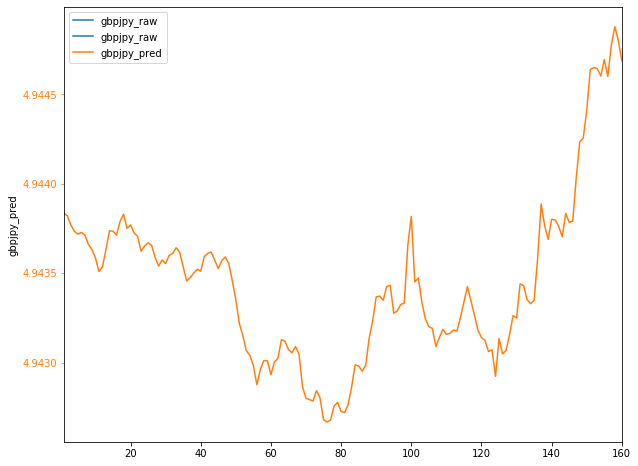

In [126]:
plot_multi(pd.DataFrame(gbpjpy_dict), figsize=(10, 8))

In [148]:
plot_df.loc[:5,['gbpjpy_pred', 'timestamp']]

,gbpjpy_pred,timestamp
0,4.94389,2019-05-20 06:20:00
1,4.94383,2019-05-20 06:21:00
2,4.94382,2019-05-20 06:22:00
3,4.94377,2019-05-20 06:23:00
4,4.94373,2019-05-20 06:24:00
5,4.94372,2019-05-20 06:25:00


In [141]:
plot_df.loc[-2:,['gbpjpy_raw', 'timestamp']]

,gbpjpy_raw,timestamp
0,4.943861,2019-05-20 06:20:00
1,4.943811,2019-05-20 06:21:00
2,4.943819,2019-05-20 06:22:00
3,4.943747,2019-05-20 06:23:00
4,4.943726,2019-05-20 06:24:00
...,...,...
156,4.944560,2019-05-20 08:59:00
157,4.944837,2019-05-20 09:00:00
158,4.944916,2019-05-20 09:01:00
159,4.944766,2019-05-20 09:02:00
